# MFEM Example 2: Linear Elasticity

This notebook walks through the formulation and solution of a linear elasticity problem in a multi-material cantilevered beam.

#### Related
* [PyMFEM/ex2.py](https://github.com/mfem/PyMFEM/blob/master/examples/ex2.py)
* [MFEM/ex2.cpp](https://github.com/mfem/mfem/blob/master/examples/ex2.cpp)

## Problem description

### Geometry

The domain of the beam, $\Omega \subset \mathbb{R}^d$ ($d \in \{2,3\}$), is composed of two materials with element attributes $1$ and $2$:
$$ \Omega = \Omega_1 \cup \Omega_2$$


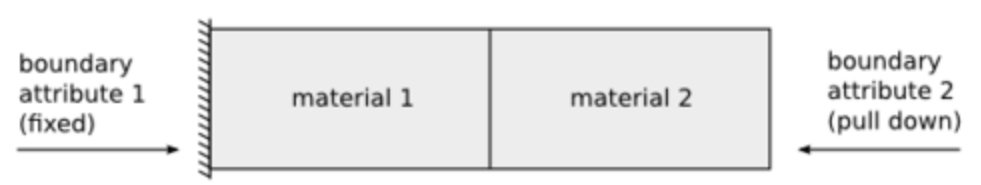


The boundary, $\partial\Omega$, is demarcated by three unique boundary conditions: $\partial\Omega_1$ is the cantilevered (fixed) end, $\partial\Omega_2$ is the opposite end exposed to a contant pulling force $\mathbf{f}$, and $\partial\Omega_3$ consists of all other parts of the boundary with no loads.
$$ \partial\Omega = \partial\Omega_1 \cup \partial\Omega_2 \cup \partial\Omega_3 $$

### Strong form
The governing equation in strong form is

\begin{equation}
-\nabla \cdot \sigma(\mathbf{u}) = \mathbf{0} ~~\text{in}~~ \Omega
\end{equation}

where $\sigma(\mathbf{u})$ is the Cauchy stress tensor, a function of the displacement field, $\mathbf{u}(\mathbf{x})$. For isotropic materials, $\sigma$ can conveniently be described as:

$$ \sigma(\mathbf{u}) = \lambda\,\nabla\cdot\mathbf{u}\,\mathrm{I} + \mu\,(\nabla \mathbf{u} + \nabla \mathbf{u}^T) ~~\text{in}~~ \Omega$$

where $\lambda$ and $\mu$ are the Lamé constants and $\mathrm{I}$ is the identity tensor. Note that because $\Omega$ consists of two different materials, $\lambda$ and $\mu$ are piecewise continuous functions.

#### Boundary conditions

The cantilevered end ($\partial\Omega_1$) has a homogeneous Dirichlet boundary condition:

$$\mathbf{u}=\mathbf{0} ~~\text{on}~~ \partial\Omega_1$$

The opposite end ($\partial\Omega_2$) has a Neumann boundary representing a constant pulling force in the last dimension; e.g. in 3 dimensions:

$$\sigma(\mathbf{u}) \cdot \mathbf{n} = \mathbf{f} = \begin{bmatrix} 0 & 0 & f_0 \end{bmatrix}^T ~\text{on}~ \partial\Omega_2$$

On the free parts of the boundary is a homogeneous Neumann boundary condition, which simply vanishes in the weak form.

$$ \sigma(\mathbf{u}) \cdot \mathbf{n} = \mathbf{0} ~\text{on}~ \partial\Omega_3$$

#### Index notation
The equations of elasticity are commonly written in [index notation](https://en.wikipedia.org/wiki/Einstein_notation). We rewrite the equation and boundary conditions in index notation to illustrate a weak form similar to the `MFEM` [bilinear](https://mfem.org/bilininteg/) and [linear](https://mfem.org/lininteg/) integrators. Indices after a comma denote differentiation (e.g. $u_{i,j} = \nabla u_i$ , $u_{i,i} = \nabla \cdot u_i$)

$$ -\sigma_{ij,j} = 0  ~~\text{in}~~ \Omega $$
$$ \sigma_{ij} = c_{ijkl} u_{k,l}$$
$$ c_{ijkl} = \lambda\,\delta_{kl} + \mu\,(\delta_{ik} \delta_{jl} + \delta_{il}\delta_{jk})$$

\begin{align}
u_i &= 0 ~~\text{on}~~ \partial\Omega_1 \\
\sigma_{ij} n_j &= f_i ~~\text{on}~~ \partial\Omega_2 \\
\sigma_{ij} n_j &= 0 ~~\text{on}~~ \partial\Omega_3
\end{align}

##### Aside
$\sigma_{ij} = c_{ijkl} u_{k,l}$ is often written as $\sigma_{ij} = c_{ijkl} \varepsilon_{k,l}$ where $\varepsilon_{k,l} = \frac12 (u_{k,l} + u_{l,k})$ is the strain tensor. These statements are equivalent due to symmetry of the stiffness tensor and decomposition of the deformation gradient into its symmetric and anti-symmetric pair. For further details, Nonlinear Finite Elements for Continua and Structures by Ted Belytschko and The Finite Element Method by Tom Hughes are excellent resources.

### Weak form

Multiply by a test function, $v$, and integrate over the domain

$$ - \int_\Omega \sigma_{ij,j} \, v_i = 0 $$

Integrate by parts and apply the divergence theorem

$$ \int_\Omega \sigma_{ij} \, v_{i,j} = \int_{\partial\Omega_2} v_i \, \sigma_{ij} \, n_j $$

Substitute expressions
$$ \int_\Omega v_{i,j}\,c_{ijkl} \, u_{k,l} = \int_{\partial\Omega_2} v_i \, f_i $$

This can alternatively be written explicitly as bilinear and linear forms:
$$ a(u,v) = L(v) $$
$$ \boxed{ a(u,v) = \int_\Omega v_{i,j}\,c_{ijkl} \, u_{k,l} } $$
$$ \boxed{ L(v) = \int_{\partial\Omega_2} v_i \, f_i } $$

### Defining the weak form in MFEM

The `MFEM` implementation of $a(u,v)$ and $L(v)$ is found by referencing the tables of [bilinear](https://mfem.org/bilininteg/) and [linear](https://mfem.org/lininteg/) integrators.

$a(u,v)$ matches the form of `ElasticityIntegrator` after swapping the definition of indices $j$ and $k$.
$$ (c_{ikjl}\nabla u_j, \nabla v_i) $$
$L(v)$ matches the form of `VectorBoundaryLFIntegrator`

# MFEM Implementation

### Imports

In [ ]:
# Requires pymfem and pyglvis see https://github.com/glvis/pyglvis
import mfem.ser as mfem
from glvis import glvis, to_stream
from math import log, floor

### Settings

In [ ]:
DATA_DIR     = '../../data' # PyMFEM data for running examples
MESH_NAME    = 'beam-hex'   # One of {beam-tri, beam-tet, beam-quad, beam-hex, beam-quad-nurbs, beam-hex-nurbs}
MAX_EL       = 5000         # Maximum number of elements
FE_ORDER     = 1            # Order of finite element space
USE_STATCOND = True         # Use static condensation
PCG_CONFIG   = dict(print_iter   = 1,    # Settings for PCG linear solver
                    max_num_iter = 500, 
                    RTOLERANCE   = 1e-8, 
                    ATOLERANCE   = 0.0)

### Load mesh
First, load the mesh from a local file. We can handle triangular, quadrilateral, tetrahedral, or hexahedral elements with the same code.

In [ ]:
mesh = mfem.Mesh(f"{DATA_DIR}/{MESH_NAME}.mesh")
dim  = mesh.Dimension()

if mesh.attributes.Max() != 2 or mesh.bdr_attributes.Max() != 3:
    raise Exception("Input mesh should have two materials and three boundary attributes!")

### Refine mesh
Refine mesh uniformly 'ref_levels' times. 'ref_levels' is chosen as the largest number that gives a final mesh with $\leq5000$ elements

In [ ]:
ref_levels = floor(log(MAX_EL/mesh.GetNE())/log(2)/dim)
for x in range(ref_levels):
    mesh.UniformRefinement()

### Define finite element space on mesh

[MFEM Documentation - Bilinear Form Integrators](https://mfem.org/bilininteg/) provides a full list of bilinear form integrators available in `MFEM`.

Our unknown, $u$, is a vector-valued function with dimension equal to the geometric dimension of the mesh, `dim`. We therefore define vector finite elements from $H^1$ on our mesh.

In [ ]:
fec     = mfem.H1_FECollection(FE_ORDER, dim)
fespace = mfem.FiniteElementSpace(mesh, fec, dim)

print("Number of finite element unknowns: " + str(fespace.GetTrueVSize()))

In [ ]:
# Determine the list of true (i.e. conforming) essential boundary dofs (boundary 1).
ess_tdof_list = mfem.intArray()
ess_bdr       = mfem.intArray([1, 0, 0])
# ess_tdof_list is appended with essential true dofs
fespace.GetEssentialTrueDofs(ess_bdr, ess_tdof_list)

### Define the solution vector, $x$

In [ ]:
x = mfem.GridFunction(fespace)
x.Assign(0.0) # initial guess of 0 satisfies BC

### Setup the bilinear form, $a(u,v)$
Recall that $a(u,v) = \int_\Omega v_{i,j}\,c_{ijkl} \, u_{k,l} $, which matches the form of `mfem.ElasticityIntegrator`

In [ ]:
λ = mfem.PWConstCoefficient(mfem.Vector([50, 1]))
μ = mfem.PWConstCoefficient(mfem.Vector([50, 1]))
a = mfem.BilinearForm(fespace)
a.AddDomainIntegrator(mfem.ElasticityIntegrator(λ, μ))

### Setup the linear form, $L(v)$
Recall that $L(v) = \int_{\partial\Omega_2} v_i \, f_i$, which matches the form of `mfem.VectorBoundaryLFIntegrator`

In [ ]:
f = mfem.VectorArrayCoefficient(dim)
for i in range(dim - 1):
    f.Set(i, mfem.ConstantCoefficient(0.0))
pull_force = mfem.Vector([0, -1.0e-2, 0]) # Omega_1, Omega_2, Omega_3
f.Set(dim - 1, mfem.PWConstCoefficient(pull_force))

b = mfem.LinearForm(fespace)
b.AddBoundaryIntegrator(mfem.VectorBoundaryLFIntegrator(f))

### Assemble

In [ ]:
if (USE_STATCOND):
    a.EnableStaticCondensation()
a.Assemble()
b.Assemble()

A = mfem.OperatorPtr()
B = mfem.Vector()
X = mfem.Vector()
a.FormLinearSystem(ess_tdof_list, x, b, A, X, B)

### Solve using PCG

In [ ]:
# Solve
AA = mfem.OperatorHandle2SparseMatrix(A)
M = mfem.GSSmoother(AA)
mfem.PCG(AA, M, B, X, **PCG_CONFIG)

# Recover the solution as a finite element grid function.
a.RecoverFEMSolution(X, b, x)

In [ ]:

# 13. For non-NURBS meshes, make the mesh curved based on the finite element
#     space. This means that we define the mesh elements through a fespace
#     based transformation of the reference element. This allows us to save
#     the displaced mesh as a curved mesh when using high-order finite
#     element displacement field. We assume that the initial mesh (read from
#     the file) is not higher order curved mesh compared to the chosen FE
#     space.
if not mesh.NURBSext:
    mesh.SetNodalFESpace(fespace)

# 14. Save the displaced mesh and the inverted solution (which gives the
#     backward displacements to the original grid). This output can be
#     viewed later using GLVis: "glvis -m displaced.mesh -g sol.gf".
nodes = mesh.GetNodes()
nodes += x
x *= -1
mesh.Print('displaced.mesh', 8)
x.Save('sol.gf', 8)

### Plot the Solution with GLVis

In [ ]:
# Plot the mesh + solution (all GLVis keys and mouse commands work)
glvis((mesh, x), 400, 400)

In [ ]:
# Plot the mesh only
glvis(mesh)

In [ ]:
# Visualization with additional GLVis keys
g = glvis(to_stream(mesh,x) + 'keys ARjlmcbp*******')
g.set_size(600, 400)
g